将句子嵌入到向量序列找那个，然后将其展平，最后在上面训练一个 Dense 层。

使用预训练的词嵌入。

# 下载 IMDB 数据的原始文本

在 http://ai.stanford.edu/~amaas/data/sentiment/ 下载原始 IMDB 数据集并解压。

将训练评论转换成字符串列表，每个字符串对应一条评论。

In [3]:
import os

imdb_dir = r'D:\data\test\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

# 对数据进行分词

对文本进行分词，并将其划分为训练集和验证集。因为预训练的词嵌入对训练数据很少的问题特别有用（否则，针对具体任务的嵌入可能效果更好），所以我们又添加了以下限制：将训练数据限定为前 200 个样本。因此，需要读取 200 个样本之后学习对电影评论进行分类。

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 在 100 个单词后截断评论
training_samples = 200  # 在 200 个样本上训练
validation_samples = 10000  # 在 10000 个样本上验证
max_words = 10000  # 只考虑数据集中前 10000 个最常见的单词

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)  # texts 是文本列表，每一条就是一个评论
sequences = tokenizer.texts_to_sequences(texts)  # 文本转换为整数序列

word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 88582 unique tokens.


In [5]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [6]:
# 将数据划分为训练集和验证集，但首先要打断数据，因为一开始数据中的样本是排好序的（负面评论在前，正面评论在后）
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

# 下载 GolVe 词嵌入

在 https://nlp.stanford.edu/projects/glove/ 下载 2014 年英文维基百科的预计算嵌入。这是一个822 MB 的压缩文件，文件名是glove.6B.zip，里面包含 400 000 个单词（或非单词的标记）的100 维嵌入向量。解压文件。

# 对嵌入进行预处理

将解压后的文件 .txt 进行解析，构建一个将单词映射为其向量表示的索引

In [8]:
glove_dir = r'D:\data\test\glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


接下来，需要构建一个可以加载到 Embedding 层中的嵌入矩阵。它必须是一个形状为 (max_words, embedding_diim) 的矩阵，对于单词索引中索引为 i 的单词，这个矩阵元素 i 就是这个单词的 embedding_dim 向量。注意，索引 0 不代表任何单词或标记，只是一个占位符。

In [9]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# 定义模型

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


# 在模型中载入 GloVe 嵌入

Embedding 层中只有一个权重矩阵，是一个二维的浮点数矩阵，每个元素 i 是与索引 i 相关的词向量。将准备好的 GloVe 矩阵加载到 Embedding 层中。

In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

此外，需要冻结 Embedding 层，即将 `trainable` 属性设置为 `False`，其原理和预训练的卷积神经网络特征相同。

# 训练和评估模型

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 118ms/step - loss: 1.2457 - acc: 0.4800 - val_loss: 1.2538 - val_acc: 0.4990
Epoch 2/10
7/7 [==============================] - 1s 96ms/step - loss: 0.6600 - acc: 0.6550 - val_loss: 0.9502 - val_acc: 0.5003
Epoch 3/10
7/7 [==============================] - 1s 94ms/step - loss: 0.5961 - acc: 0.6750 - val_loss: 1.0774 - val_acc: 0.5040
Epoch 4/10
7/7 [==============================] - 1s 93ms/step - loss: 0.3386 - acc: 0.8650 - val_loss: 1.4710 - val_acc: 0.5010
Epoch 5/10
7/7 [==============================] - 1s 100ms/step - loss: 0.3173 - acc: 0.8700 - val_loss: 0.7278 - val_acc: 0.5569
Epoch 6/10
7/7 [==============================] - 1s 95ms/step - loss: 0.1056 - acc: 1.0000 - val_loss: 0.7852 - val_acc: 0.5407
Epoch 7/10
7/7 [==============================] - 1s 97ms/step - loss: 0.0773 - acc: 1.0000 - val_loss: 0.9829 - val_acc: 0.5165
Epoch 8/10
7/7 [==============================] - 1s 94ms/step - loss: 0.1956 - acc: 0.9300 - v

# 绘制结果

绘制模型性能随时间的变化

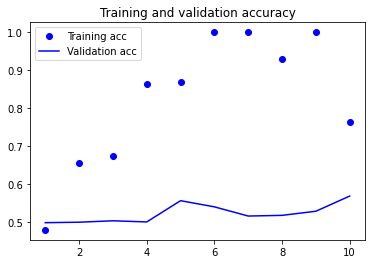

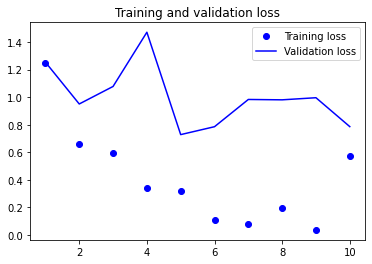

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

模型很快就开始过拟合，考虑到训练样本很少，这一点不奇怪。出于同样的原因，验证精度的波动很大，但接近 60%。

训练样本数太少，所以模型性能严重依赖于你选择的 200 个样本，而样本是随机选择的。

也可以在不加载预训练词嵌入、也不冻结嵌入层的情况下训练相同的模型。此时，模型学到针对任务的输入标记的嵌入，如果有大量可用的数据，这种方法通常比预训练词嵌入更加强大，但本例只有 200 个训练样本。下面尝试一下

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 125ms/step - loss: 0.6961 - acc: 0.5000 - val_loss: 0.6909 - val_acc: 0.5241
Epoch 2/10
7/7 [==============================] - 1s 93ms/step - loss: 0.5111 - acc: 0.9750 - val_loss: 0.6938 - val_acc: 0.5228
Epoch 3/10
7/7 [==============================] - 1s 98ms/step - loss: 0.3039 - acc: 0.9950 - val_loss: 0.7148 - val_acc: 0.5127
Epoch 4/10
7/7 [==============================] - 1s 95ms/step - loss: 0.1434 - acc: 1.0000 - val_loss: 0.7028 - val_acc: 0.5362
Epoch 5/10
7/7 [==============================] - 1s 93ms/step - loss: 0.0679 - acc: 1.0000 - val_loss: 0.7147 - val_acc: 0.5281
Epoch 6/10
7/7 [==============================] - 1s 93ms/step - loss: 0.0347 - acc: 1.0000 - val_loss: 0.7215 - val_acc: 0.5367
Epoch 7/10
7/7 [==============================] - 1s 92ms/step - loss: 0.0186 - acc: 1.0000 - val_loss: 0.7558 - val_acc: 0.5185
Epoch 8/10
7/7 [==============================] - 1s 92ms/step - loss: 0.0114 - acc: 1.0000 - va

验证精度停留在 50% 多一点。因此，在本例中，预训练词嵌入的性能要比与任务一起学习的嵌入好。如果增加样本量，情况会很快发生变化。

最后，在测试集上评估模型。首先，需要对测试数据进行分词。

In [17]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)